In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold

from plotnine import *

%matplotlib inline

pd.options.display.max_rows = 20
%load_ext autotime


/home/subaevdi/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

feat_all = train.columns[2:]
feat_categ = train.dtypes.index[train.dtypes == 'object']
feat_not_uniq = ['X289',
 'X235',
 'X347',
 'X268',
 'X11',
 'X107',
 'X233',
 'X330',
 'X290',
 'X293',
 'X297',
 'X93']

feat_numb = list(set(feat_all) - set(feat_categ) - set(feat_not_uniq))


time: 415 ms


In [4]:
train['test'] = 0
test['test'] = 1

df = pd.concat([train, test], axis=0).reset_index()
y = train.y
df = df.drop(["ID", "y"], axis=1)
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

ix_train = df.test == 0
ix_test = df.test == 1
bind_y = y < 154.68696

y_rej = y[bind_y]

Train shape :  (4209, 379)
Test shape :  (4209, 378)
time: 142 ms


In [17]:
#set(test.X0) - set(train.X0)




time: 4.72 ms


In [18]:
test[test.X0.isin(['ae', 'ag', 'an', 'av', 'bb', 'p'])]

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X376,X377,X378,X379,X380,X382,X383,X384,X385,test


time: 16.4 ms


In [14]:
train.X0.value_counts()

z     360
ak    349
y     324
ay    313
t     306
x     300
o     269
f     227
n     195
w     182
     ... 
r      10
as     10
bc      6
ao      4
c       3
aa      2
q       2
ac      1
g       1
ab      1
Name: X0, Length: 47, dtype: int64

time: 7.58 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


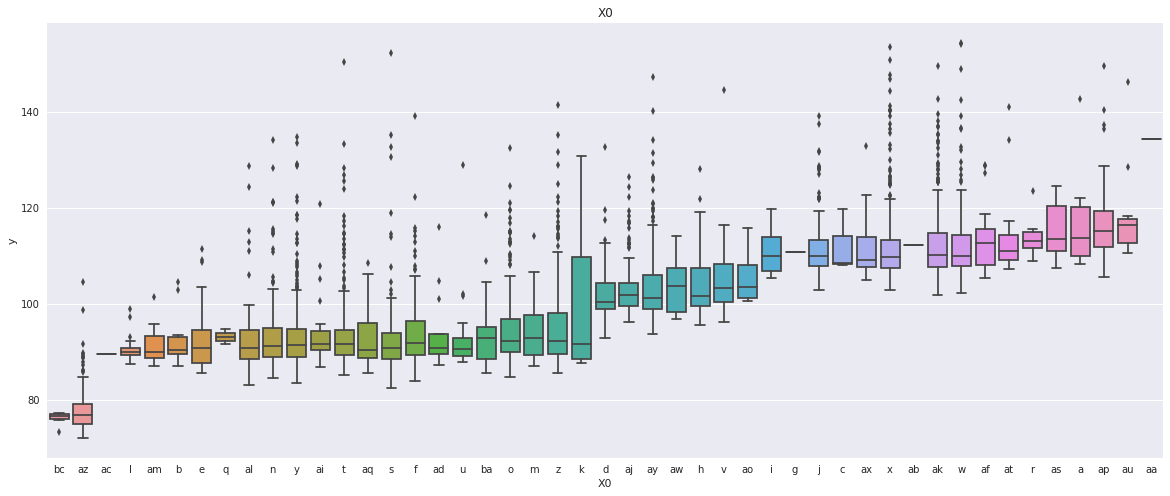

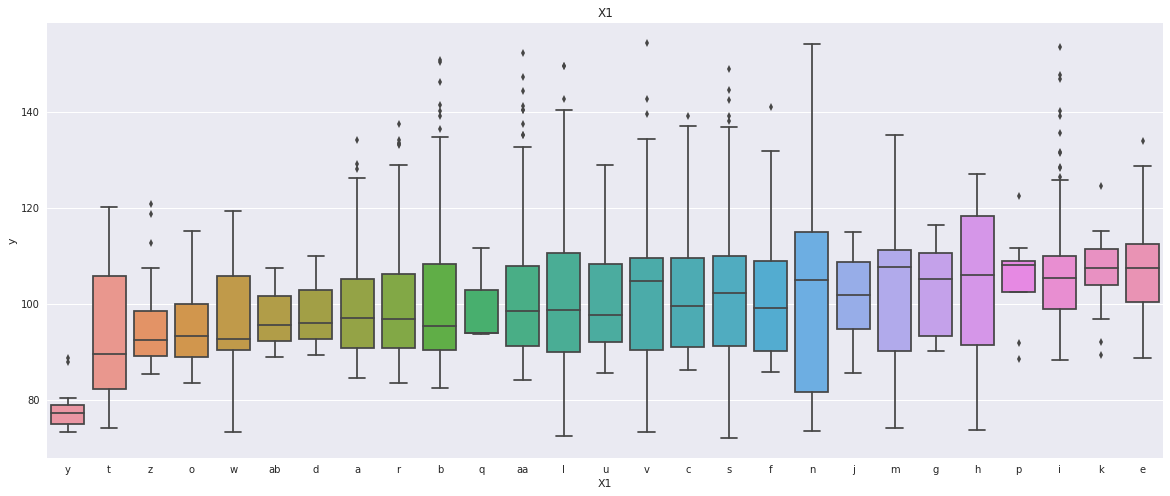

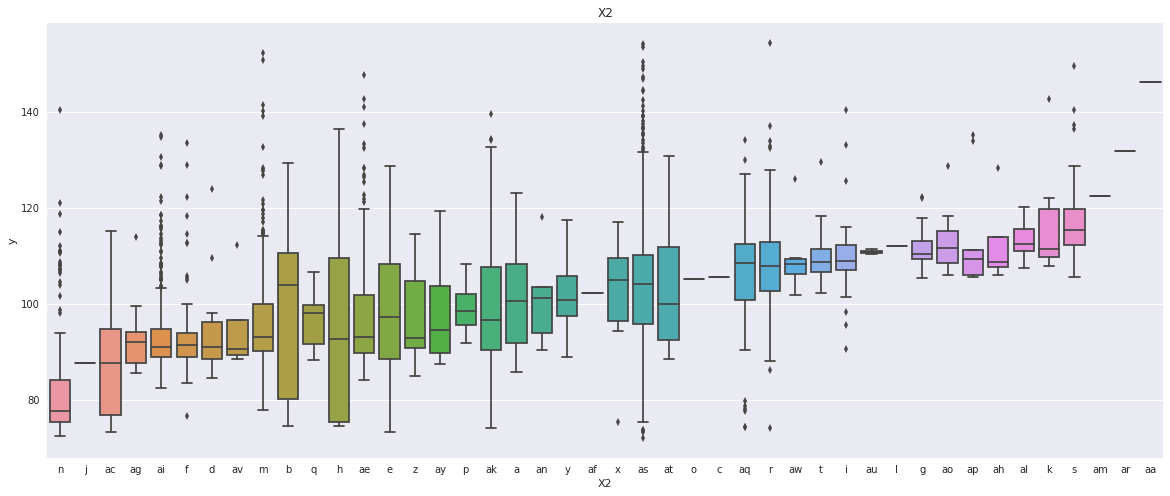

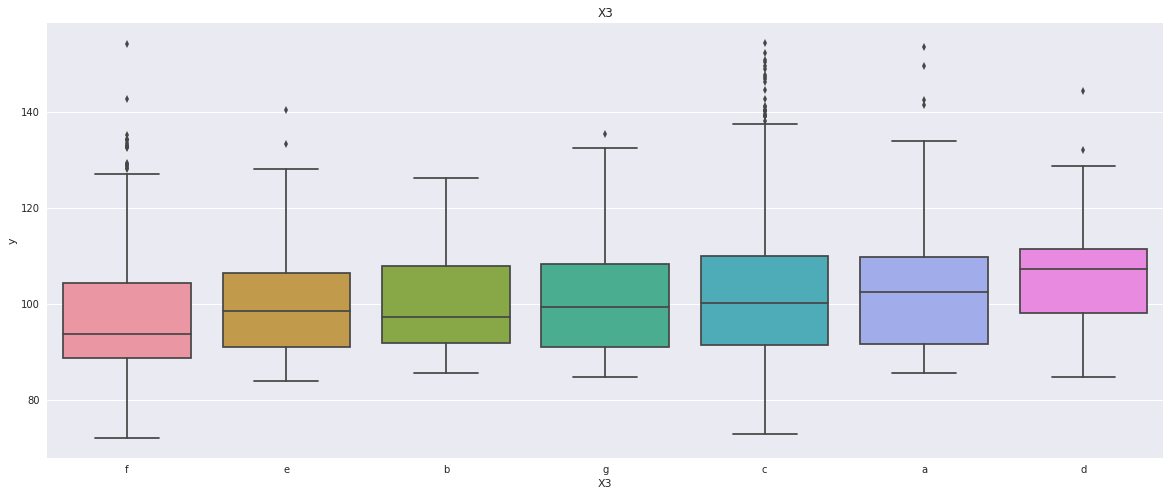

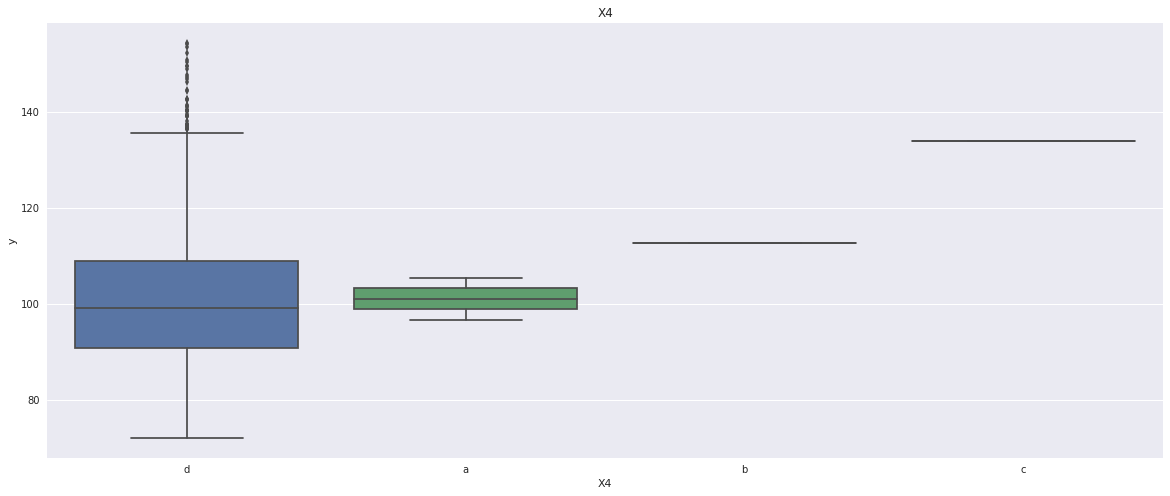

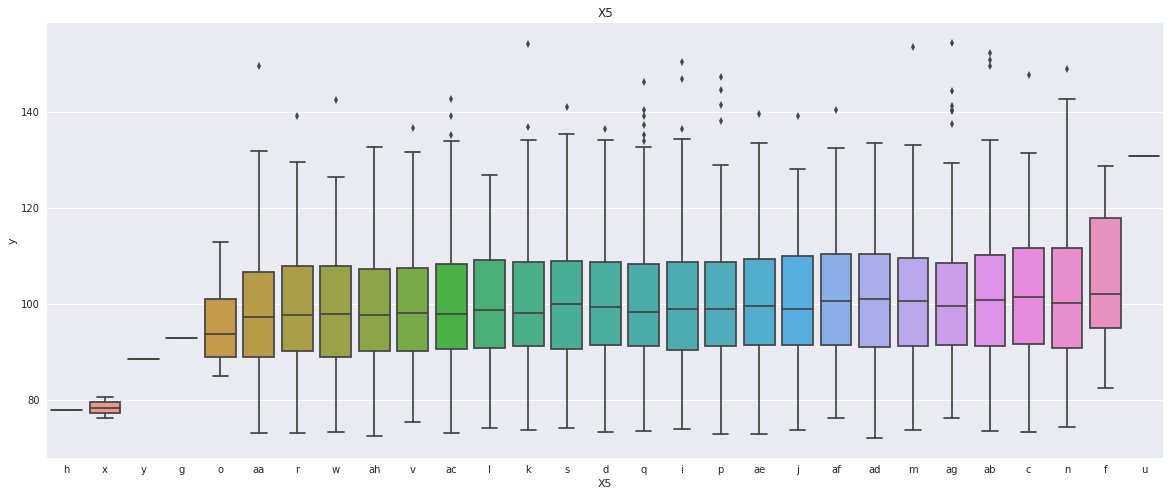

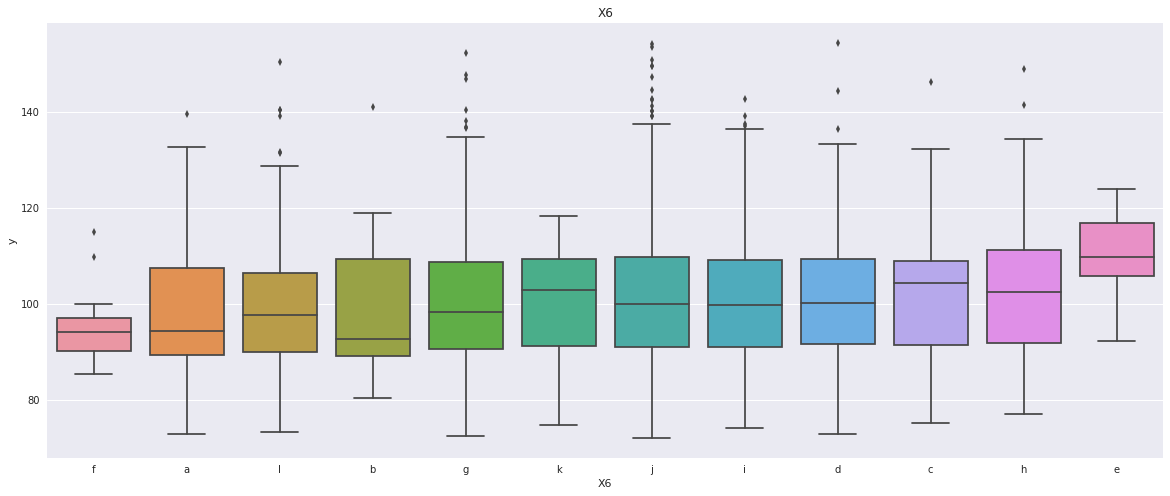

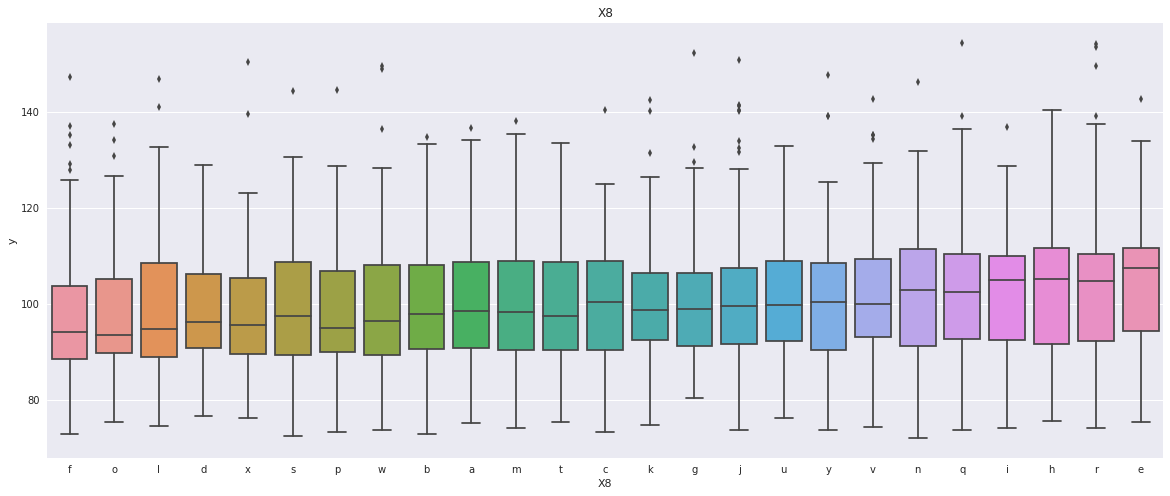

time: 7.28 s


In [51]:
for col in feat_categ:
    df_tmp_gr = pd.DataFrame({col:df[ix_train][bind_y][col], 'y':y_rej}).\
        groupby(col).mean().sort_values('y')
    plt.figure(figsize=(20,8))
    sns.boxplot(data=df[ix_train][bind_y], x=col, y=y_rej, order=df_tmp_gr.index.values)
    plt.title(col)
    plt.show()

In [13]:
le = LabelEncoder()
val = le.fit_transform(df[ix_train][bind_y].X0)
ohe = OneHotEncoder()

X = ohe.fit_transform(val.reshape(-1,1))
feat_ohe = ['ohe_' + str(i) for i in np.arange(X.shape[1])]
X_ohe = pd.DataFrame(X.todense(), columns=feat_ohe)

X_ohe['Inresept'] = 1

model = sm.OLS(y_rej.values, X_ohe)
results = model.fit()
print(results.summary())
coef = results.params

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     145.5
Date:                Fri, 07 Jul 2017   Prob (F-statistic):               0.00
Time:                        12:26:07   Log-Likelihood:                -14431.
No. Observations:                4200   AIC:                         2.896e+04
Df Residuals:                    4153   BIC:                         2.925e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ohe_0         15.6960      1.665      9.429      0.0

In [16]:

model = KMeans(n_clusters=4)
clusters = model.fit_predict(train.y.values.reshape(-1,1))

df_tmp = pd.DataFrame({'X0':train.X0, 'y':train.y, 'cluster':clusters})
for cl in df_tmp.cluster.unique():
    t = df_tmp[df_tmp.cluster == cl]
    #print(np.mean(t.y), t.shape)
    #print(t.X0.value_counts())

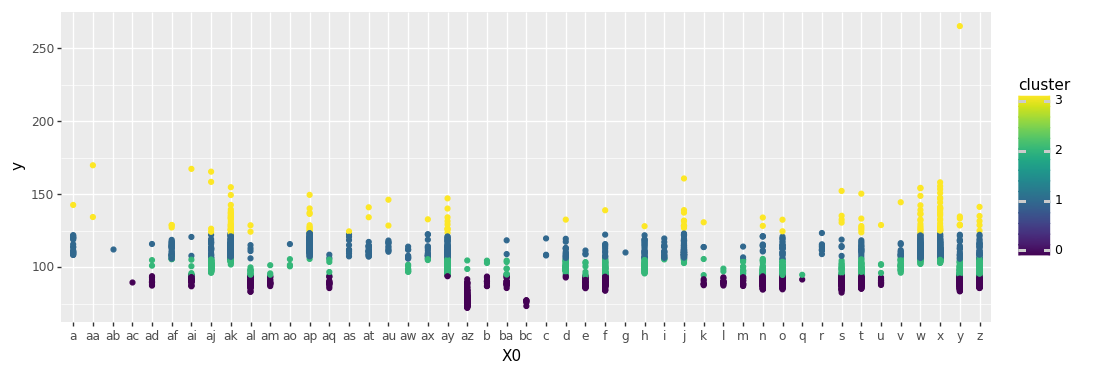

<ggplot: (-9223363291843181431)>

time: 1.62 s


In [19]:
(ggplot(df_tmp, aes(x='X0',y='y', color ='cluster'))
 + geom_point() + theme(figure_size=(12, 8), # inches
    aspect_ratio=1/3))
#+ stat_smooth(method='lm')
#+ facet_wrap('~gear')
#+ theme_xkcd())

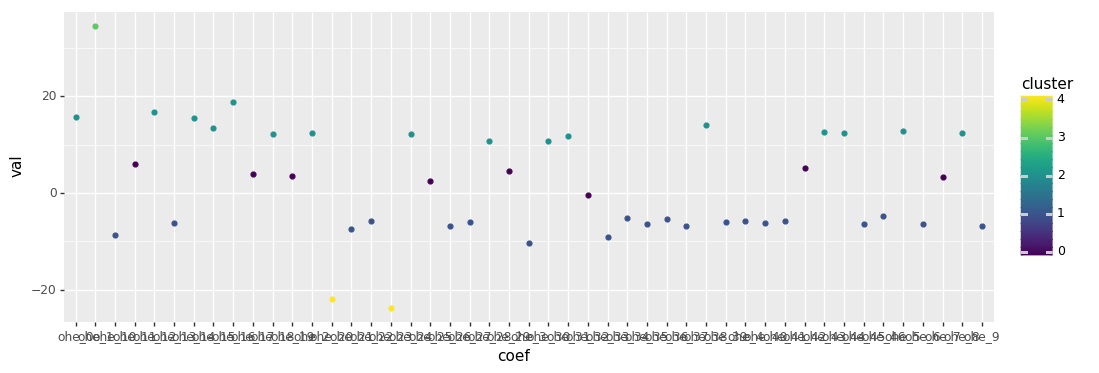

<ggplot: (8745002112804)>

time: 1.2 s


In [20]:
model = KMeans(n_clusters=5)
coef_prd = coef[:-1]
clusters = model.fit_predict(coef_prd.values.reshape(-1,1))
df_tmp = pd.DataFrame({'coef':coef_prd.index, 'val':coef_prd.values, 'cluster':clusters})

(ggplot(df_tmp, aes(x='coef', y='val', color='cluster'))
 + geom_point() + stat_smooth(method='lm') + theme(figure_size=(12, 8), # inches
    aspect_ratio=1/3))

In [21]:
df_tmp.groupby('cluster').agg(['mean', 'count'])

val      
              mean count
cluster                 
0         3.572721     8
1        -6.599628    20
2        13.406264    16
3        34.495003     1
4       -22.824726     2

time: 12.4 ms


In [22]:
coef[-1]

99.934997332061045

time: 3.07 ms


In [23]:
test.X0.value_counts().loc[['bb', 'ae', 'an', 'ag', 'av', 'p']]
test[test.X0.isin(['bb', 'ae', 'an', 'ag', 'av', 'p'])][['ID', 'X0']]

,ID,X0
153,289,av
311,624,ag
2914,5816,an
3281,6585,ae
3718,7420,p
3913,7805,bb


time: 13 ms


In [24]:
# 153 av
# LB -59.22568
y_pred = np.zeros(4209)
y_pred[153] = 99.93499-6.599628
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros153clust1.csv", index=False)

# LB -59.22967
y_pred = np.zeros(4209)
y_pred[153] = 99.93499+13.406264
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros153clust0.csv", index=False)

# LB -59.22661
y_pred = np.zeros(4209)
y_pred[153] = 99.93499-22.824726
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros153clust2.csv", index=False)
#

time: 40.8 ms


In [ ]:
# 311 ag
#
ind = 311

# LB XXXX
y_pred = np.zeros(4209)
y_pred[ind] = 99.93499-6.599628
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros" + str(ind) + "clust1.csv", index=False)

# LB -59.28220
y_pred = np.zeros(4209)
y_pred[ind] = 99.93499+13.406264
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros" + str(ind) + "clust0.csv", index=False)

# LB XXXX
y_pred = np.zeros(4209)
y_pred[ind] = 99.93499-22.824726
pd.DataFrame({'ID':test.ID, 'y':y_pred}).to_csv("../submit/zeros" + str(ind) + "clust2.csv", index=False)

# Кластарезация по X0
1. Построить лин. регрессию по X0 OHE
2. Кластарезовать коэфициенты -> уменьшит их кол-во
3. Построить новую линейную регресию на объеденных X0

# Cluster 7 LB SCORE 0.50984
# Cluster 10 LB SCORE 0.54828


In [53]:
for CLUST_NUMB in [5, 6, 7, 10, 11]:
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    y = train.y
    le = LabelEncoder().fit(pd.concat([train.X0, test.X0]))

    # Кодируем X0 в трейне и тесте
    X0_le, test_X0_le = le.transform(train.X0), le.transform(test.X0)

    ohe = OneHotEncoder()
    X0_ohe = ohe.fit_transform(X0_le.reshape(-1,1))

    # Словарь соответствия кода X0 номеру коэф в регрессии
    d_le_coef = dict([(le,i) for i, le in enumerate(ohe.active_features_)], )

    # Вычисляем регрессию для всех кодов
    model = LinearRegression().fit(X0_ohe, y)

    # 47 коэф. регресси по кластерм
    coef_clust = KMeans(n_clusters=CLUST_NUMB).fit_predict(model.coef_.reshape(-1,1))

    # Найти код Х0 в списке коэфицинтов по кластерам
    X0_clust = np.array([coef_clust[ d_le_coef.get(x0_code) ] for x0_code in X0_le])

    # Если кода нету в трейне и для него не рассчитан коэфициент, то присвоить значение самого массового кластера
    POPULAR_CLUSTER = pd.DataFrame({'cl':X0_clust}).cl.value_counts().index[0]

    test_X0_clust = np.array(
        [coef_clust[ d_le_coef.get(x0_code, POPULAR_CLUSTER) ] 
                              for x0_code in test_X0_le])

    X0_ohe, test_X0_ohe = ohe.fit_transform(X0_clust.reshape(-1, 1)),\
        ohe.transform(test_X0_clust.reshape(-1, 1))

    res = cross_val_score(LinearRegression(), X0_ohe, y, scoring='r2', cv=kf)

    model = LinearRegression().fit(X0_ohe, y)
    y_sumbit = model.predict(test_X0_ohe)

    # LB  0.50984
    pd.DataFrame({'ID':test.ID, 'y':y_sumbit}).to_csv("../submit/clustering_coef_X0_cluster"+str(CLUST_NUMB)+".csv", index=False)

time: 494 ms


In [41]:
feat_clust = ['clust_' + str(i) for i in np.arange(X0_ohe.shape[1])]


<4209x7 sparse matrix of type '<class 'numpy.float64'>'
	with 4209 stored elements in Compressed Sparse Row format>

time: 3.87 ms
